<a href="https://colab.research.google.com/github/mansikataria/FacialExpressionRecognition/blob/main/FacialExpressionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install watermark
%load_ext watermark
%watermark -a 'Mansi Kataria' -v -p torch

  Found existing installation: importlib-metadata 4.6.0
    Uninstalling importlib-metadata-4.6.0:
      Successfully uninstalled importlib-metadata-4.6.0
Author: Mansi Kataria

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

torch: 1.9.0+cu102



Reading the FER2013 dataset from the CSV

In [2]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.insert(0,BASE_PATH)

FER2013_PATH_FILE_NAME = 'fer2013.csv'

data = pd.read_csv(BASE_PATH + '/' + FER2013_PATH_FILE_NAME)

print(data)


       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [5]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Visualizations on the data:

1. Let's see the class distribution

In [6]:
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


Plotting a bar graph with these values:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


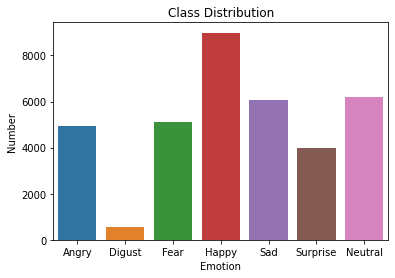

In [7]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class Distribution')
plt.ylabel('Number', fontsize=10)
plt.xlabel('Emotion', fontsize=10)
plt.show()

Plotting some sample images:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

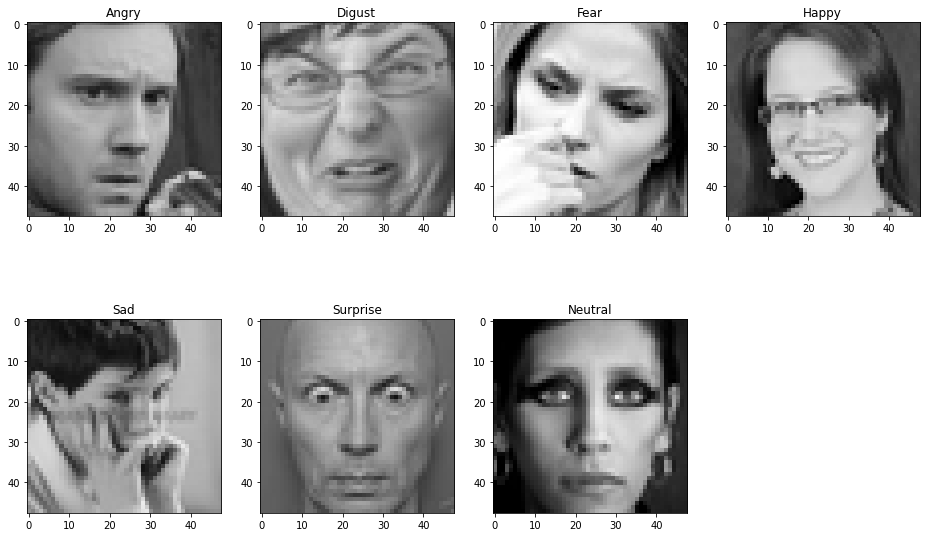

In [8]:
def row2Image(row):
  pixels, emotions = row['pixels'] , emotion_map[row['emotion']]
  img = np.array(pixels.split())
  img = img.reshape((48, 48))
  image = np.zeros((48, 48, 3))
  image[:,:, 0] = img
  image[:,:, 1] = img
  image[:,:, 2] = img
  return np.array([image.astype(np.uint8), emotions])

plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
  face = data[data['emotion'] == i-1].iloc[0]
  img = row2Image(face)
  plt.subplot(2,4,i)
  plt.imshow(img[0])
  plt.title(img[1])

plt.show()

Splitting data into train, test and validation sets:


In [9]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy() 
data_test = data[data['Usage'] == 'PrivateTest'].copy()

print("Train Shape: {}\nTest Shape: {}\nValidation Shape: {}".format(data_train.shape, data_test.shape, data_val.shape));

Train Shape: (28709, 3)
Test Shape: (3589, 3)
Validation Shape: (3589, 3)


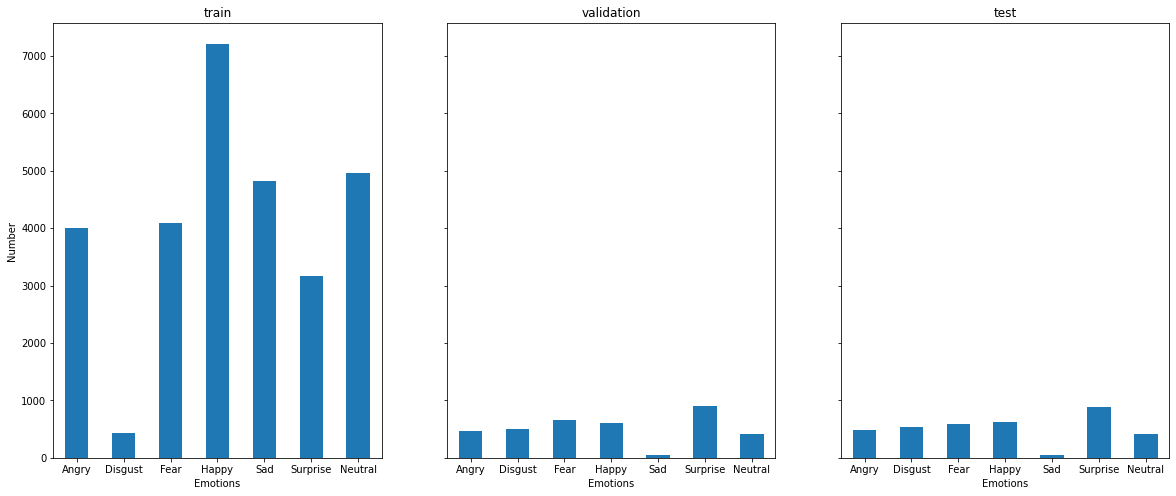

In [10]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [11]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [12]:
#image preprocessing:

def preprocess(df):
  #Convert string to int
  df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  #reshape and normalize
  data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0 
  data_Y = to_categorical(df['emotion'], num_classes) 
  print("X shape: {},  Y shape: {}".format(data_X.shape, data_Y.shape))
  return data_X, data_Y

print('Preprocessing Training Data...')
data_train_X, data_train_Y = preprocess(data_train)
print('Preprocessing Testing Data...')
data_test_X, data_test_Y = preprocess(data_test)
print('Preprocessing Validation Data...')
data_val_X, data_val_Y = preprocess(data_val)


Preprocessing Training Data...
X shape: (28709, 48, 48, 1),  Y shape: (28709, 7)
Preprocessing Testing Data...
X shape: (3589, 48, 48, 1),  Y shape: (3589, 7)
Preprocessing Validation Data...
X shape: (3589, 48, 48, 1),  Y shape: (3589, 7)


In [13]:
print(data_train_X[:1])
print(data_train_Y[:5])


[[[[0.27450982]
   [0.3137255 ]
   [0.32156864]
   ...
   [0.20392157]
   [0.16862746]
   [0.16078432]]

  [[0.25490198]
   [0.23921569]
   [0.22745098]
   ...
   [0.21960784]
   [0.20392157]
   [0.17254902]]

  [[0.19607843]
   [0.16862746]
   [0.21176471]
   ...
   [0.19215687]
   [0.21960784]
   [0.18431373]]

  ...

  [[0.35686275]
   [0.25490198]
   [0.16470589]
   ...
   [0.28235295]
   [0.21960784]
   [0.16862746]]

  [[0.3019608 ]
   [0.32156864]
   [0.30980393]
   ...
   [0.4117647 ]
   [0.27450982]
   [0.18039216]]

  [[0.3019608 ]
   [0.28235295]
   [0.32941177]
   ...
   [0.41568628]
   [0.42745098]
   [0.32156864]]]]
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [14]:
data_train_X[:1].shape

(1, 48, 48, 1)

Building a CNN Model:

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,  MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam

In [21]:
#create model
model = Sequential()

# Layer 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Layer 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Layer 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Flatten
model.add(Flatten())

#FC Layer1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#FC Layer2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#FC Layer3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#model compile specifics
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_9 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_10 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_10 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_11 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 256)      

In [22]:
path_model=BASE_PATH + '/fer_model'

#Train the model
history = model.fit(data_train_X, data_train_Y, batch_size=batch_size, validation_data=(data_val_X, data_val_Y), shuffle=True, epochs=50)
model.save(path_model)

Epoch 1/50
449/449 [==============================] - 49s 103ms/step - loss: 1.7391 - categorical_accuracy: 0.3177 - val_loss: 1.8060 - val_categorical_accuracy: 0.2825
Epoch 2/50
449/449 [==============================] - 45s 100ms/step - loss: 1.2374 - categorical_accuracy: 0.5286 - val_loss: 1.3181 - val_categorical_accuracy: 0.5216
Epoch 3/50
449/449 [==============================] - 44s 99ms/step - loss: 1.0647 - categorical_accuracy: 0.5977 - val_loss: 1.1964 - val_categorical_accuracy: 0.5436
Epoch 4/50
449/449 [==============================] - 44s 99ms/step - loss: 0.9284 - categorical_accuracy: 0.6481 - val_loss: 1.2713 - val_categorical_accuracy: 0.5394
Epoch 5/50
449/449 [==============================] - 44s 99ms/step - loss: 0.8122 - categorical_accuracy: 0.7004 - val_loss: 1.2537 - val_categorical_accuracy: 0.5475
Epoch 6/50
449/449 [==============================] - 45s 99ms/step - loss: 0.6717 - categorical_accuracy: 0.7535 - val_loss: 1.3657 - val_categorical_accurac

Visualizing Training Accuracy

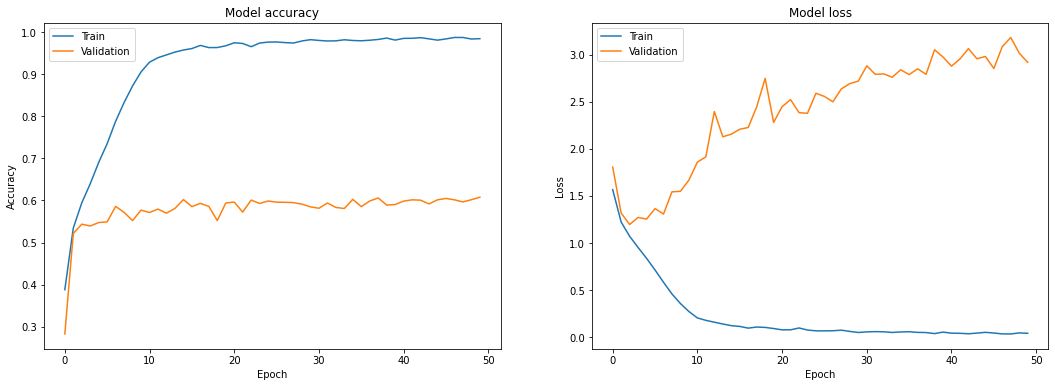

In [24]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
#Add some more data using augmentation
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

history = model.fit(data_generator.flow(data_train_X, data_train_Y, batch_size),
                                steps_per_epoch=len(data_train_X) / batch_size,
                                epochs=50,
                                validation_data=(data_val_X, data_val_Y))
model.save(path_model)



Epoch 1/50
448/448 [==============================] - 46s 100ms/step - loss: 1.3474 - categorical_accuracy: 0.5574 - val_loss: 1.0880 - val_categorical_accuracy: 0.6024
Epoch 2/50
448/448 [==============================] - 44s 99ms/step - loss: 1.0608 - categorical_accuracy: 0.6026 - val_loss: 1.0421 - val_categorical_accuracy: 0.6172
Epoch 3/50
448/448 [==============================] - 45s 100ms/step - loss: 1.0158 - categorical_accuracy: 0.6204 - val_loss: 1.0303 - val_categorical_accuracy: 0.6325
Epoch 4/50
448/448 [==============================] - 45s 101ms/step - loss: 0.9848 - categorical_accuracy: 0.6310 - val_loss: 1.0439 - val_categorical_accuracy: 0.6225
Epoch 5/50
448/448 [==============================] - 45s 101ms/step - loss: 0.9637 - categorical_accuracy: 0.6359 - val_loss: 1.0203 - val_categorical_accuracy: 0.6344
Epoch 6/50
448/448 [==============================] - 46s 101ms/step - loss: 0.9497 - categorical_accuracy: 0.6459 - val_loss: 1.0045 - val_categorical_accu

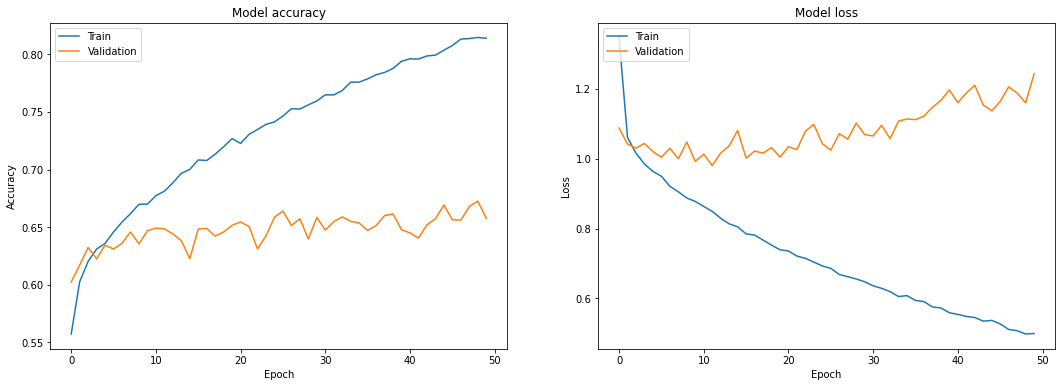

In [26]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()